# Feature Engineering & Model's

## Libraries

In [ ]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import joblib
import itertools


## Global Variables

In [6]:
# Input paths
PATH_DATAFRAME = 'full_join.xlsx'

## Global Functions

In [8]:
def polars_read_excel(file_name, sheet_name='Sheet1'):
  return pl.read_excel(source=file_name, sheet_name=sheet_name)

## Import data

In [9]:
df = polars_read_excel(PATH_DATAFRAME)

Could not determine dtype for column 20, falling back to string
Could not determine dtype for column 21, falling back to string
Could not determine dtype for column 22, falling back to string
Could not determine dtype for column 23, falling back to string
Could not determine dtype for column 24, falling back to string


In [10]:
df = df.with_columns([
    pl.col("CostImpact (€)").cast(pl.Float64, strict=False),
])

## Data Manipulation

In [11]:
# Filter out "Uncertain" from the original PackagingQuality
df = df.filter(pl.col("PackagingQuality") != "Uncertain")

In [12]:
df_input = (
    df 
    .sort("DateOfReport")
    .select([
        "DateOfReport",
        "SupplierName",
        "GarmentType",
        "Material",
        "Weight",
        "ProposedUnitsPerCarton",
        "ProposedFoldingMethod",
        "ProposedLayout",
        "Size",
        "Collection",
        "PackagesHandled",             
        "TotalIncidents",             
        "AnomaliesDetected",          
        "BadPackagingRate (%)",        
        "OnTimeDeliveryRate (%)",      
        "AverageCostPerIncident (€)",  
        "PackagingQuality",
    ])
)

### Target Variable

In [13]:
# Convert Polars to Pandas
df_pd = df_input.to_pandas()

# Encode target variable
df_pd["PackagingQuality"] = df_pd["PackagingQuality"].map({"Good": 1, "Bad": 0})

# Define features and target
X = df_pd.drop(columns=["PackagingQuality","DateOfReport"])
y = df_pd["PackagingQuality"]

In [14]:
### Identify categorical columns
categorical_features = X.select_dtypes(include="object").columns.tolist()

### Split dataset

In [15]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

In [ ]:
# Do this for both X_train and X_test
for col in categorical_features:
    if col in X_train.columns: # Check if column exists
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

## Model

In [21]:
#weights
class_weights = np.where(y_train == 1, 1, 4)  


# Instantiate the LightGBM classifier
model_lgb = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

actual_categorical_in_train = [col for col in categorical_features if col in X_train.columns and X_train[col].dtype.name == 'category']

# Train the model
model_lgb.fit(X_train, y_train, sample_weight=class_weights,categorical_feature=actual_categorical_in_train)
# Make predictions on the test set
y_pred_lgb = model_lgb.predict(X_test)
y_proba_lgb = model_lgb.predict_proba(X_test)[:, 1]



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 266177, number of negative: 65569
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 331746, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503691 -> initscore=0.014764
[LightGBM] [Info] Start training from score 0.014764


### Evaluation

In [22]:
#summary report
print(classification_report(y_test, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.30      0.70      0.42     28101
           1       0.89      0.59      0.71    114076

    accuracy                           0.61    142177
   macro avg       0.59      0.65      0.56    142177
weighted avg       0.77      0.61      0.65    142177



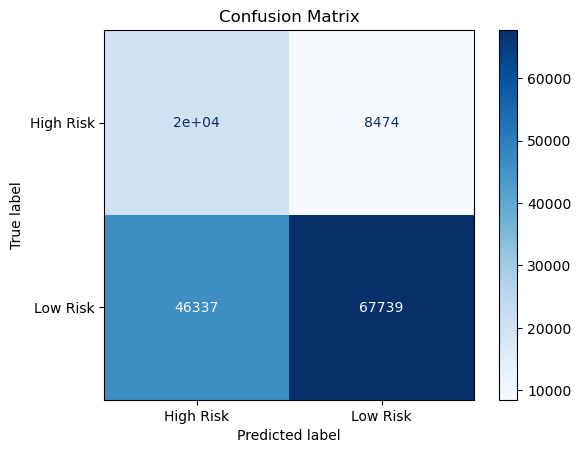

In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["High Risk", "Low Risk"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

AUC: 0.6862


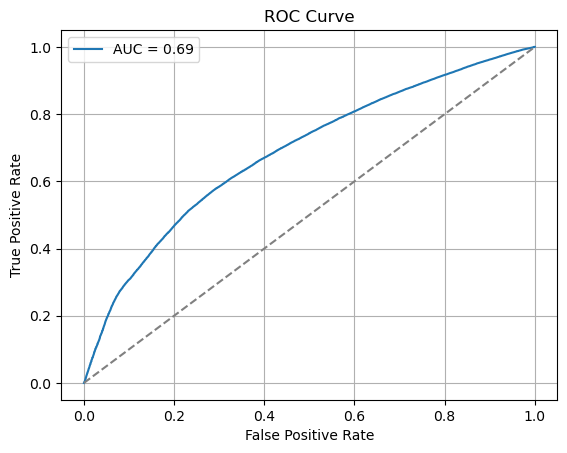

In [24]:
# AUC score
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.4f}")

# Optional: plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Get feature names and importance values
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model_lgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
importance_df

,Feature,Importance
3,Weight,6446
4,ProposedUnitsPerCarton,5065
14,AverageCostPerIncident (€),2327
9,PackagesHandled,2080
10,TotalIncidents,1869
13,OnTimeDeliveryRate (%),1735
12,BadPackagingRate (%),1619
5,ProposedFoldingMethod,1545
1,GarmentType,1505
11,AnomaliesDetected,1402


In [26]:
# bring back dateofreport to the final dataframe
final_df = X_test.copy()
final_df['DateOfReport'] = df_pd.loc[X_test.index, 'DateOfReport'].values
# now we add the predictions
final_df['PredictedQuality'] = y_pred_lgb
final_df['PredictedQualityProba'] = y_proba_lgb
final_df['ActualQuality'] = y_test.values

final_df

,SupplierName,GarmentType,Material,Weight,ProposedUnitsPerCarton,ProposedFoldingMethod,ProposedLayout,Size,Collection,PackagesHandled,TotalIncidents,AnomaliesDetected,BadPackagingRate (%),OnTimeDeliveryRate (%),AverageCostPerIncident (€),DateOfReport,PredictedQuality,PredictedQualityProba,ActualQuality
252159,SupplierA,T-Shirt,Polyester,0.12,39,Method1,LayoutB,M,Winter,7786.0,185.0,17.0,8.42,87.44,573.12,2023-10-18,1,0.771456,1
233515,SupplierG,Shorts,Polyester,0.23,20,Method2,LayoutB,M,Summer,1426.0,50.0,7.0,16.55,75.58,637.83,2023-09-26,1,0.509485,1
245649,SupplierH,Shirt,Polyester,0.18,39,Method1,LayoutA,M,Spring,865.0,57.0,11.0,38.62,61.70,563.93,2023-10-10,0,0.253761,1
101085,SupplierE,Dress,Cotton,0.53,17,Method1,LayoutB,XS,Spring,2329.0,81.0,20.0,22.33,67.45,551.40,2023-04-27,1,0.551453,1
235264,SupplierA,Shirt,Polyester,0.15,36,Method2,LayoutB,S,Autumn,8205.0,178.0,21.0,8.10,93.59,532.82,2023-09-28,1,0.823766,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325363,SupplierE,Dress,Cotton,0.43,33,Method1,LayoutC,M,Summer,2377.0,107.0,15.0,23.01,77.06,611.66,2024-01-11,0,0.477274,1
427575,SupplierD,Dress,Cotton,0.54,17,Method2,LayoutC,L,Winter,2859.0,126.0,19.0,32.14,68.93,516.82,2024-05-08,0,0.401155,1
18263,SupplierE,Pants,Polyester,0.39,21,Method2,LayoutB,S,Winter,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-22,0,0.494484,1
220341,SupplierG,Suit,Wool,1.11,7,Method3,LayoutD,XL,Summer,1426.0,50.0,7.0,16.55,75.58,637.83,2023-09-11,0,0.389744,1


## Saving the model and datasets

In [ ]:
#  Save the Trained LightGBM Model
if 'model_lgb' in locals():
    try:
        joblib.dump(model_lgb, 'lightgbm_model.joblib')
    except Exception as e:
        print(f"ERROR saving model_lgb: {e}")

#  Save the "Pure" X_test DataFrame 
if 'X_test' in locals() and isinstance(X_test, pd.DataFrame):
    try:
        X_test.to_parquet('X_test_model_features.parquet')
    except Exception as e_parq:
        # Try CSV as a fallback if Parquet fails
        try:
            X_test.to_csv('X_test_model_features.csv', index=False)
        except Exception as e_csv:
            print(f"ERROR saving X_test (Parquet failed: {e_parq}, CSV failed: {e_csv})")


#  Savefinal_df DataFrame 
if 'final_df' in locals() and isinstance(final_df, pd.DataFrame):
    try:
        if 'DateOfReport' in final_df.columns and final_df['DateOfReport'].dtype != '<M8[ns]':
            final_df['DateOfReport'] = pd.to_datetime(final_df['DateOfReport'])
        final_df.to_parquet('final_df_for_analysis.parquet')
    except Exception as e_parq:
        # Try CSV as a fallback
        try:
            final_df.to_csv('final_df_for_analysis.csv', index=False)
        except Exception as e_csv:
            print(f"ERROR saving final_df (Parquet failed: {e_parq}, CSV failed: {e_csv})")